In [1]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import nilearn

from nilearn import plotting
from nilearn import datasets
from nilearn import image
from nilearn.image import mean_img

# Let us use a Nifti file that is shipped with nilearn
from nilearn.datasets import MNI152_FILE_PATH

/Users/home/.local/lib/python3.8/site-packages/nilearn/datasets/__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
os.getcwd()

'/Users/home/Documents/GitHub/MVPA-speech_project/MVPA-project-admin'

In [3]:
# Set variables
root_data='/Users/home/Documents/BIDS/'
sub='sub-0001'
ses='ses-001'
file_sep="/"

# data folder
data_path=root_data+file_sep+sub+file_sep+ses
print('The data is in this folder - '+data_path)

# project folder
root_project="/Users/home/Documents/GitHub/MVPA-speech_project"



The data is in this folder - /Users/home/Documents/BIDS//sub-0001/ses-001


# Structural data.

## Check registration using FSL BET (brain extraction) + FEAT

/Users/home/.local/lib/python3.8/site-packages/nilearn/image/resampling.py:527: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


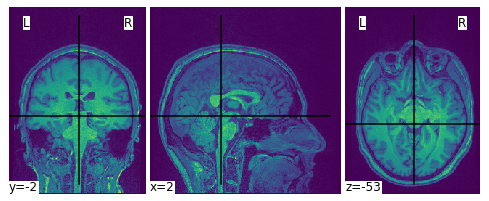

In [4]:
t1w_file_path=data_path+'/anat/sub-0001_ses-001_run-01_T1w.nii.gz'
plotting.plot_img(t1w_file_path)

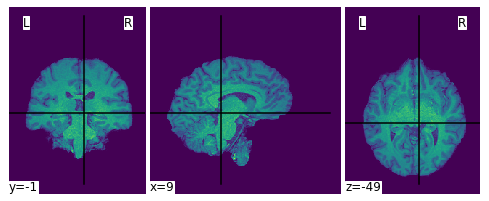

In [5]:
t1w_brain_file_path='/Users/home/Documents/BIDS/sub-0001/ses-001/anat/sub-0001_ses-001_run-01_T1w_brain.nii.gz'

plotting.plot_img(t1w_brain_file_path)

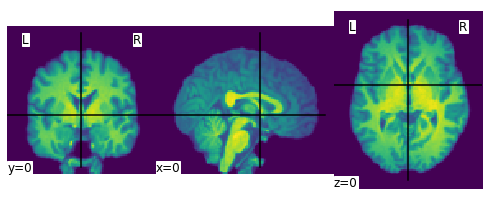

In [6]:
t1w_prepro_file_path='/Users/home/Documents/BIDS/sub-0001/ses-001/run-1.feat/reg/highres2standard.nii.gz'

cut_coords=(0, 0, 0)
plotting.plot_img(t1w_prepro_file_path, cut_coords)

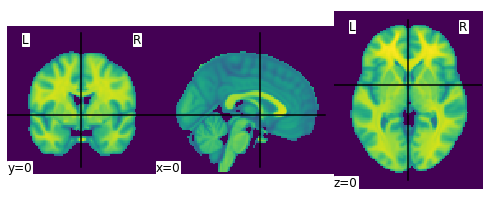

In [7]:
# (0,0,0) no standard MNI (mas tb em Talairach) aponta sempre para uma estrutura anatómica chamada de comissura anterior.
plotting.plot_img(datasets.MNI152_FILE_PATH, cut_coords)

# Functional data.
## Check preprocessing using FSL FEAT

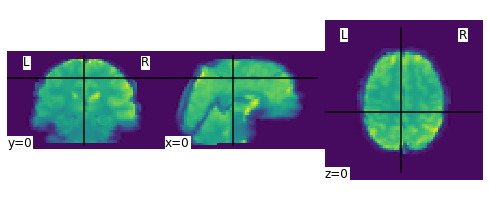

In [8]:
func_data_preproc='/Users/home/Documents/BIDS/sub-0001/ses-001/run-1.feat/filtered_func_data.nii.gz'

mean_fmri_img=mean_img(func_data_preproc)
plotting.plot_img(mean_fmri_img, cut_coords)

(91, 109, 91)


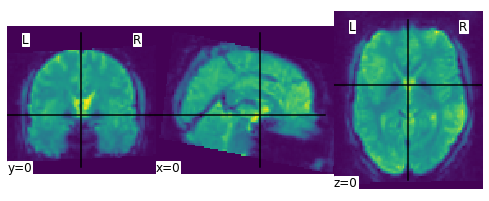

In [9]:
func_data_preproc_2high='/Users/home/Documents/BIDS/sub-0001/ses-001/run-1.feat/reg/example_func2standard.nii.gz'

mean_fmri_img_2high=mean_img(func_data_preproc_2high)

print(image.load_img(func_data_preproc_2high).shape)

plotting.plot_img(mean_fmri_img_2high, cut_coords)

(91, 109, 91, 222)


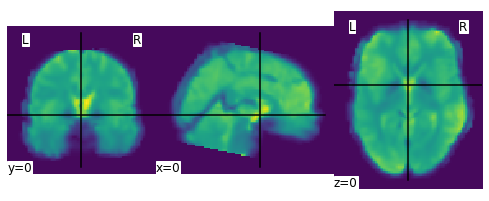

In [10]:
func_data_preproc2standard='/Users/home/Documents/BIDS/sub-0001/ses-001/run-1.feat/filtered_func_data2standard.nii.gz'
print(image.load_img(func_data_preproc2standard).shape)

mean_fmri_img_2standard=mean_img(func_data_preproc2standard)
plotting.plot_img(mean_fmri_img_2standard, cut_coords)

## Look at the events and design matrix.

In [11]:
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.plotting import plot_design_matrix

tr = 2.5  # repetition time is ? second
n_scans = 222  # the acquisition comprises ?? scans
frame_times = np.arange(n_scans) * tr  # here are the correspoding frame times

# load events.tsv
events_PATH='/Users/home/Documents/GitHub/MVPA-speech_project/convert-bids-admin/DOCKER/events.tsv'

events_df = pd.read_csv(events_PATH, sep='\t', na_values="n/a")
print(events_df.head())

print(frame_times[:5])


  trial_type  onset  duration
0  Baseline     0.0      12.5
1      Task    15.0      27.5
2  Baseline    45.0      12.5
3      Task    60.0      27.5
4  Baseline    90.0      12.5
[ 0.   2.5  5.   7.5 10. ]


In [12]:
# load events.tsv
events_PATH='/Users/home/Documents/GitHub/MVPA-speech_project/convert-bids-admin/DOCKER/betaseries_fonologico.tsv'

events_df = pd.read_csv(events_PATH, sep='\t', na_values="n/a")
print(events_df.head(10))



   trial_type  onset  duration
0           0    0.0       2.5
1           1    2.5       2.5
2           2    5.0       2.5
3           3    7.5       2.5
4           4   10.0       2.5
5           5   12.5       2.5
6           6   15.0       2.5
7           7   17.5       2.5
8           8   20.0       2.5
9           9   22.5       2.5


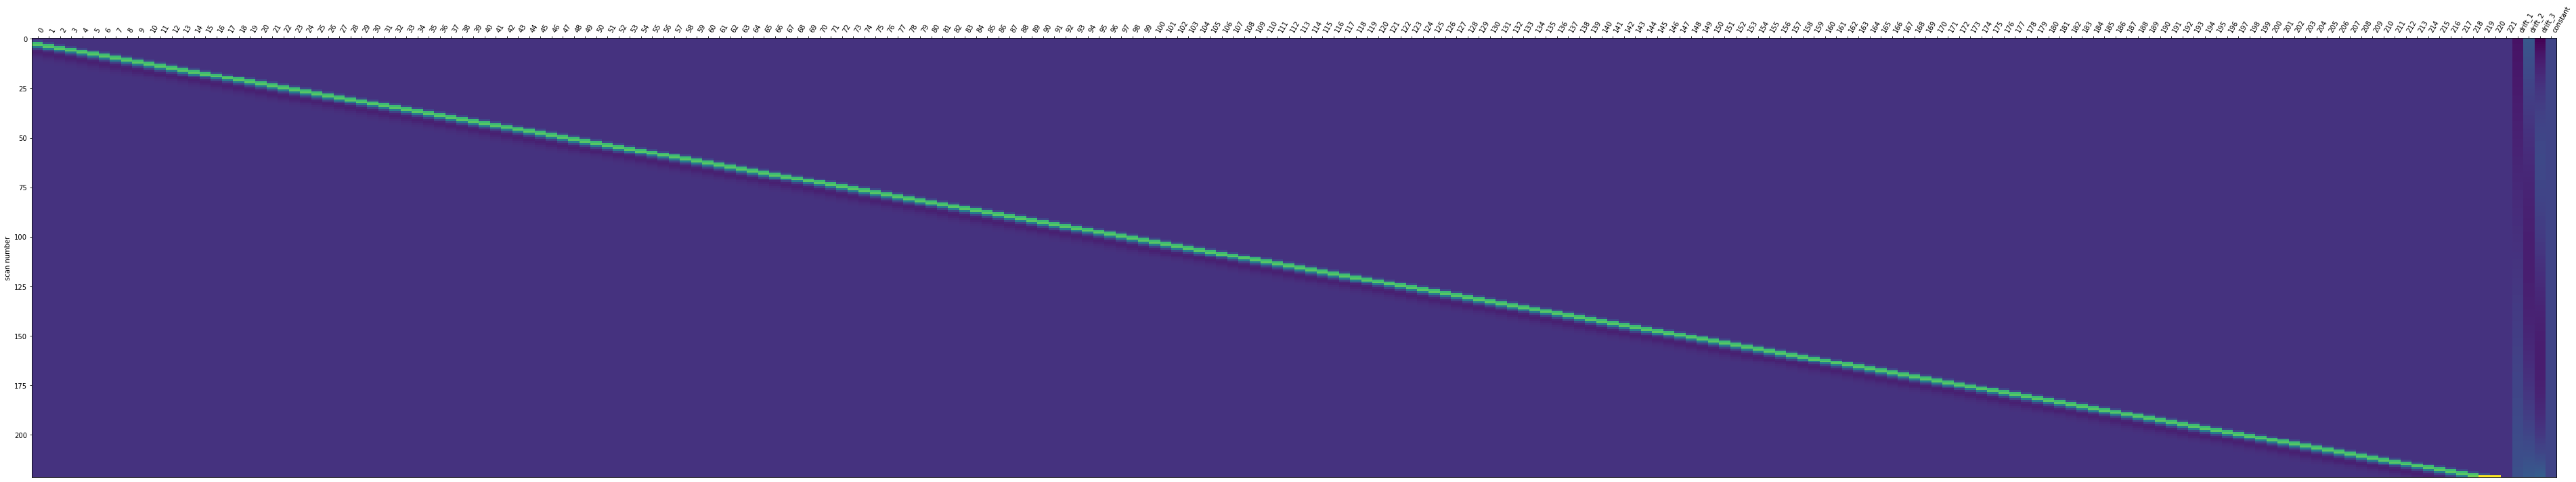

In [32]:
hrf_model='spm'
design_matrix = make_first_level_design_matrix(frame_times, events_df,
                                    drift_model='polynomial', drift_order=3,
                                    hrf_model=hrf_model)

plot_design_matrix(design_matrix)

**Statistical analysis - 1st level**

In [33]:
contrast_matrix = np.eye(design_matrix.shape[1])
basic_contrasts = dict([(column, contrast_matrix[i])
                        for i, column in enumerate(design_matrix.columns[:-4])])


In [35]:
from nilearn.glm.first_level import FirstLevelModel

fmri_img='/Users/home/Documents/BIDS/sub-0001/ses-001/func/sub-0001_ses-001_task-fonologico_run-01_bold.nii.gz'

print('Fitting a GLM')
fmri_glm = FirstLevelModel()
fmri_glm.fit(fmri_img, design_matrices=design_matrix)

Fitting a GLM


FirstLevelModel(signal_scaling=True)

In [60]:
z_maps=[]
for contrast in basic_contrasts:
    z_maps.append(fmri_glm.compute_contrast(basic_contrasts[contrast], output_type='z_score'))

/Users/home/.local/lib/python3.8/site-packages/nilearn/_utils/niimg.py:61: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(
/Users/home/.local/lib/python3.8/site-packages/nilearn/plotting/displays.py:880: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


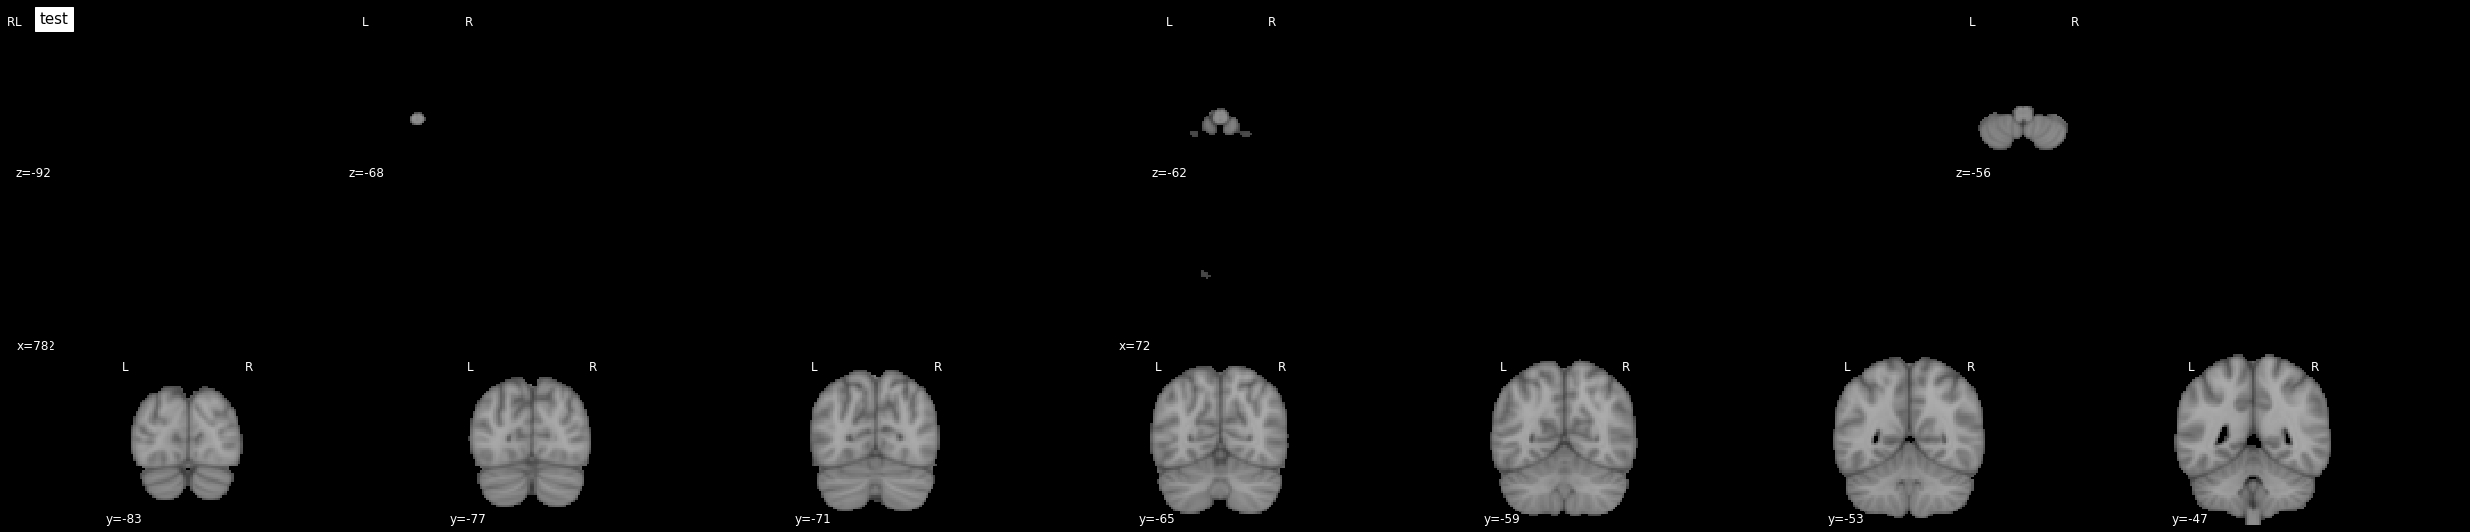

In [64]:
# plot the contrasts 
# the display is overlayed on the mean fMRI image
# a threshold of 3.0 is used, more sophisticated choices are possible
plotting.plot_stat_map(
    z_maps[10], threshold=0, display_mode='mosaic', black_bg=True, title='test')
plotting.show()



# Decoding


In [ ]:
# brain_mask = datasets.load_mni152_brain_mask()

from nilearn.datasets import fetch_icbm152_brain_gm_mask
brain_mask = fetch_icbm152_brain_gm_mask()

In [ ]:
from nilearn.decoding import Decoder 

decoder = Decoder(estimator='svc', mask=brain_mask) 

In [ ]:
plotting.plot_roi(brain_mask, bg_img=t1w_prepro_file_path,
                  cmap='Paired')

In [ ]:
fmri_niiimgs=image.load_img(func_data_preproc2standard)
fmri_niiimgs.shape

In [ ]:
idxs=events_df['onset']/tr
conditions = []

for i in range(len(events_df)):
    idx_2=((events_df['duration'][i]/tr))+1
    for j in range(int(idx_2)):
        conditions.append(events_df['trial_type'][i])

In [ ]:

baseline="Baseline "
baselineidxs=[]

for idx,condition in enumerate(conditions):
    if(condition == baseline):
        baselineidxs.append(idx)

print(baselineidxs)


task="Task "
taskidxs=[]

for idx,condition in enumerate(conditions):
    if(condition == task):
        taskidxs.append(idx)

print(taskidxs)


In [ ]:
from nilearn.image import index_img
trainset = index_img(fmri_niiimgs, slice(0, -50))
trainset.shape

In [ ]:
decoder.fit(trainset, conditions[:-50]) 

In [ ]:
print(decoder.cv_scores_) 

In [ ]:
testset = index_img(fmri_niiimgs, slice(-50,None))
testset.shape

In [ ]:
prediction=decoder.predict(testset)

In [ ]:
print((prediction == conditions[-50:]).sum() / float(len(conditions[-50:])))

In [ ]:
plotting.view_img(
    decoder.coef_img_['Task '], bg_img=t1w_prepro_file_path,
    title="SVM weights", dim=-1
)

# dummy decoder - como avaliar a qualidade de um classificador?

In [ ]:
dummy_decoder = Decoder(estimator='dummy_classifier', mask=brain_mask)

dummy_decoder.fit(trainset, conditions[:-50]) 

dummy_prediction=dummy_decoder.predict(trainset)


In [ ]:
dummy_decoder.dummy_output_

# Functional connectivity

In [ ]:
dataset = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
atlas_filename = dataset.maps
labels = dataset.labels

#yeo = datasets.fetch_atlas_yeo_2011()
#atlas_filename=yeo['thick_17']

In [ ]:
#yeo.description


In [ ]:
coordinates = plotting.find_parcellation_cut_coords(atlas_filename)
plotting.plot_roi(atlas_filename)

In [ ]:
coordinates


In [ ]:
from nilearn.input_data import NiftiLabelsMasker
masker = NiftiLabelsMasker(labels_img=atlas_filename, standardize=True)

In [ ]:
from nilearn.image import index_img

baseline_imgs = index_img(func_data_preproc2standard, baselineidxs)
task_imgs = index_img(func_data_preproc2standard, taskidxs)

In [ ]:
baseline_series = masker.fit_transform(baseline_imgs)
task_series = masker.fit_transform(task_imgs)

In [ ]:
print(baseline_series.shape)
print(task_series.shape)

In [ ]:
from nilearn.connectome import ConnectivityMeasure
correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrix_baseline = correlation_measure.fit_transform([baseline_series])[0]

correlation_matrix_task = correlation_measure.fit_transform([task_series])[0]

# Plot the correlation matrix
import numpy as np
from nilearn import plotting
# Make a large figure
# Mask the main diagonal for visualization:
np.fill_diagonal(correlation_matrix_baseline, 0)
# The labels we have start with the background (0), hence we skip the
# first label
# matrices are ordered for block-like representation
plotting.plot_matrix(correlation_matrix_baseline, figure=(10, 8), labels=labels[1:],
                     vmax=0.8, vmin=-0.8, reorder=True)

# Make a large figure
# Mask the main diagonal for visualization:
np.fill_diagonal(correlation_matrix_task, 0)
# The labels we have start with the background (0), hence we skip the
# first label
# matrices are ordered for block-like representation
plotting.plot_matrix(correlation_matrix_task, figure=(10, 8), labels=labels[1:],
                     vmax=0.8, vmin=-0.8, reorder=True)

In [ ]:
plotting.plot_connectome(correlation_matrix_baseline, coordinates,
                         title='baseline corr',
                         edge_threshold="90%",edge_cmap="copper", colorbar="true")

plotting.plot_connectome(correlation_matrix_task, coordinates,
                         title='task corr',
                         edge_threshold="90%",edge_cmap="copper", colorbar="true")
